In [75]:
pip install lightgbm #installing lightGBM

## Importing packages ##

In [76]:
import lightgbm as lgb
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split # split data into two sets (train and test)
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import balanced_accuracy_score , roc_auc_score , make_scorer # ROC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # confusion matrix
from sklearn.metrics import plot_confusion_matrix # the drawing of confusion matrix
from sklearn.metrics import accuracy_score # accuracy score
import seaborn as sns

## Importing Data ##

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
df=pd.read_csv('/content/drive/MyDrive/Data_set/final_dataset_smes.csv') 
df.drop('Unnamed: 0',axis=1, inplace=True)
df
df["status"].value_counts()

0    13413
1     1632
Name: status, dtype: int64

## Splitting data into two (Train and Test) ##

In [79]:
var_columns = [c for c in df.columns if c !='status']
X= df.loc[:, var_columns] # the variables that we're gonna use to build our model
y= df.loc[:, 'status'] # the result we wanna acheive

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #"test_size=0.2"=>the proportion of the dataset to include in the test split X/y_valid (test 20% train 80%)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12036, 24), (3009, 24), (12036,), (3009,))

## LightGBM Model ##
We will now create the LightGBM Model

In [80]:
model_LGBM = lgb.LGBMClassifier() #LGBM Model with the default hyperparams
eval_set = [(X_test, y_test)]
model_LGBM.fit(X_train,
               y_train,
               early_stopping_rounds=10,
               eval_set=eval_set,
               verbose=True)


[1]	valid_0's binary_logloss: 0.301585
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.285756
[3]	valid_0's binary_logloss: 0.275377
[4]	valid_0's binary_logloss: 0.266394
[5]	valid_0's binary_logloss: 0.259916
[6]	valid_0's binary_logloss: 0.254679
[7]	valid_0's binary_logloss: 0.249885
[8]	valid_0's binary_logloss: 0.245753
[9]	valid_0's binary_logloss: 0.242695
[10]	valid_0's binary_logloss: 0.2399
[11]	valid_0's binary_logloss: 0.237578
[12]	valid_0's binary_logloss: 0.235167
[13]	valid_0's binary_logloss: 0.233486
[14]	valid_0's binary_logloss: 0.231912
[15]	valid_0's binary_logloss: 0.230704
[16]	valid_0's binary_logloss: 0.22919
[17]	valid_0's binary_logloss: 0.227384
[18]	valid_0's binary_logloss: 0.22625
[19]	valid_0's binary_logloss: 0.225841
[20]	valid_0's binary_logloss: 0.224544
[21]	valid_0's binary_logloss: 0.223804
[22]	valid_0's binary_logloss: 0.222929
[23]	valid_0's binary_logloss: 0.222556
[24]	valid_0's binary_logloss: 

LGBMClassifier()

Now we will evaluate the model using the auc

In [81]:
y_train_pred = model_LGBM.predict_proba(X_train)[:,1]
y_test_pred = model_LGBM.predict_proba(X_test)[:,1]

#"roc_auc_score" function will give us the area under curve metric 
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_test_pred)))

AUC Train: 0.9613
AUC Test: 0.8704


Now we will evaluate the model using the accuracy score

In [83]:

for i in range(0, X_test.shape[0]): 
    if y_test_pred[i]>=.5:       # setting threshold to .5 
       y_test_pred[i]=1 
    else: 
       y_test_pred[i]=0  

print('the accuracy of LightGBM is',accuracy_score(y_test_pred, y_test))    

the accuracy of LightGBM is 0.923562645397142


Now we will draw the confusion matrix for our first model 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


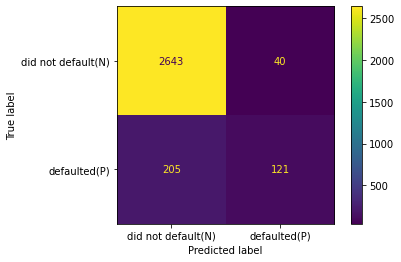

In [33]:
plot_confusion_matrix(model_LGBM,# our model
                      X_test,# test data set
                      y_test,
                     display_labels=["did not default(N)","defaulted(P)"])#set labels 

## Improoving the model ##
 we can try improving it with changing the hyper params of XGBoost's model 
by trying to find the best combination of hyper params to have the best model for us using **GridSearchCV**

In [70]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
       return_train_score=True,
       verbose=4)

    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [71]:
model = lgb.LGBMClassifier(objective='binary',metric=['auc', 'binary_logloss'],subsample_freq=20,num_leaves=50)
param_grid = {
    'boosting_type':['gbdt','dart'],
    "learning_rate":[0.02, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [15,20,25]
}
model_imp_LGBM, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=2,)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV 1/2] END boosting_type=gbdt, learning_rate=0.02, max_depth=15, n_estimators=100;, score=(train=0.939, test=0.916) total time=   0.7s
[CV 2/2] END boosting_type=gbdt, learning_rate=0.02, max_depth=15, n_estimators=100;, score=(train=0.941, test=0.916) total time=   0.7s
[CV 1/2] END boosting_type=gbdt, learning_rate=0.02, max_depth=15, n_estimators=200;, score=(train=0.967, test=0.916) total time=   1.4s
[CV 2/2] END boosting_type=gbdt, learning_rate=0.02, max_depth=15, n_estimators=200;, score=(train=0.969, test=0.918) total time=   1.3s
[CV 1/2] END boosting_type=gbdt, learning_rate=0.02, max_depth=15, n_estimators=300;, score=(train=0.990, test=0.916) total time=   5.5s
[CV 2/2] END boosting_type=gbdt, learning_rate=0.02, max_depth=15, n_estimators=300;, score=(train=0.990, test=0.918) total time=   2.0s
[CV 1/2] END boosting_type=gbdt, learning_rate=0.02, max_depth=20, n_estimators=100;, score=(train=0.940, test=0.915

In [72]:
print(model_imp_LGBM.best_score_)
print(model_imp_LGBM.best_params_)

0.9181621801262878
{'boosting_type': 'dart', 'learning_rate': 0.05, 'max_depth': 25, 'n_estimators': 300}


Now we will evaluate the model using the auc

In [73]:
y_train_pred = model_imp_LGBM.predict_proba(X_train)[:,1]
y_test_pred = model_imp_LGBM.predict_proba(X_test)[:,1]

#"roc_auc_score" function will give us the area under curve metric 
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_test_pred)))

AUC Train: 0.9867
AUC Test: 0.8684


Now we will draw the confusion matrix 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


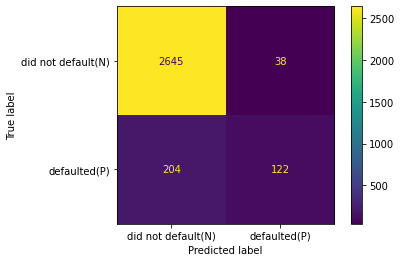

In [74]:
plot_confusion_matrix(model_imp_LGBM,# our model
                      X_test,# test data set
                      y_test,
                     display_labels=["did not default(N)","defaulted(P)"])#set labels 